### Sequence only

In [1]:
from doctorailib import doctorai
from similarity.weighted_levenshtein import WeightedLevenshtein
from similarity.weighted_levenshtein import CharacterSubstitutionInterface
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
import pickle
from sklearn.metrics import f1_score, hamming_loss, zero_one_loss, make_scorer
from sklearn.tree import DecisionTreeClassifier
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import time
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
path = '../data/'
mimic = sorted(np.load(path+'MIMIC_data/mimic_sequences.npy'))
p2p_jaccard = np.load(path+'p2p_jaccard.npy')

In [4]:
def get_closest_datapoints_indexes(start_index,dist_matrix,k):
    candidates = sorted(enumerate(dist_matrix[start_index]),key=lambda x:x[1])[:k]
    return list(candidates)

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

def wup_patient_jac(p1, p2):
    dtw = np.full((len(p1),len(p2)), 10000, dtype=np.float64)
    dtw[0,0] = 0
    for i,v1 in enumerate(p1):
        for j,v2 in enumerate(p2):
            cost = 1 - jaccard_similarity(v1,v2)
            in_cost = dtw[i-1,j] if i>0 else 0 
            del_cost = dtw[i,j-1] if j>0 else 0
            edit_cost = dtw[i-1,j-1] if i>0 and j>0 else 0
            dtw[i,j] = cost + min(in_cost,del_cost,edit_cost)
    return dtw[-1][-1]

def distance_matrix(syn_seqs, c2c):    
    dist_syn_matrix = np.full((len(syn_seqs),len(syn_seqs)),0.)
    for i in range(len(syn_seqs)):
        for j in range(len(syn_seqs)):
            dist = wup_patient(c2c, syn_seqs[i], syn_seqs[j])
            dist_syn_matrix[i][j] = dist
            dist_syn_matrix[j][i] = dist
    return dist_syn_matrix

def get_closest_datapoints(start_index,dist_matrix,k):
    candidates = sorted(enumerate(dist_matrix[start_index]),key=lambda x:x[1])[:k+1]
    return list(candidates)

def flat_dp(patient, last_visit = True):
    if last_visit:
        codes = list(set([a for b in patient for a in b]))
    else:
        codes = list(set([a for b in patient[:-1] for a in b]))
    fdp = {}
    for c in codes:  
        seq = [1 if c in el else 0 for el in patient[:-1][::-1]] #already rev
        decay = [1/2**i for i in range(1,len(patient))]
        #print(c,seq,decay,np.multiply(seq,decay),sum(np.multiply(seq,decay)))
        fdp[c]=sum(np.multiply(seq,decay))
    return fdp

def flat_cloud(kdp, last_visit = True):
    local_flat = [flat_dp(n, last_visit = last_visit) for n in kdp]
    all_codes = sorted(list(set([a for b in [list(lf.keys()) for lf in local_flat] for a in b])))
    feat_mx = np.full((len(kdp),len(all_codes)),0.)
    for row,lf in enumerate(local_flat):
        for (k,v) in lf.items():
            feat_mx[row][all_codes.index(k)]=v
    return feat_mx,all_codes

def unflat_cloud(cloud,code_list,max_past,past_mean,past_std):
    res = []
    for dp in cloud: #iterate over synthetic datapoints
        dp_mx = np.full((len(code_list),max_past),0) #codes * visits
        for col,temp_val in enumerate(dp):
            check = .5
            for visit_index in range(max_past-1,-1,-1):
                if temp_val>=check:
                    dp_mx[col,visit_index]=1
                    temp_val-=check
                check/=2
            #dp_mx matrix filled with values
        raw_seq = [[code_list[c] for c in range(dp_mx.shape[0]) if dp_mx[c,v]==1] for v in range(dp_mx.shape[1])]#
        num_visit = max(1,int(np.ceil(np.random.normal(past_mean,past_std))))
        res.append(raw_seq[-num_visit:])
    return res

def normal_perturbation_on_flat(flat_neigh, seed, size=1000):
    
    np.random.seed(seed)
    
    num_codes = flat_neigh.shape[1]
    flat_syn_neigh = np.full((size,num_codes),0.)
    
    for code_col in range(num_codes):
        code_mean = np.mean(flat_neigh[:,code_col])
        code_std = np.std(flat_neigh[:,code_col])
        flat_syn_neigh[:,code_col]=np.random.normal(code_mean,code_std,size)
        
    flat_syn_neigh[flat_syn_neigh<0.]=0.
    flat_syn_neigh[flat_syn_neigh>1.]=1.
    
    return flat_syn_neigh

def dummify_labels(labels, dict_icd2int, n_unique_codes=4880):
    dummyfied_labels = np.zeros((len(labels),n_unique_codes))
    int_labels = [[dict_icd2int[k] for k in label] for label in labels]
    for i in range(len(int_labels)):
        dummyfied_labels[i][int_labels[i]]=1
    return dummyfied_labels

def dummify_patient(patient_seq, dict_icd2int, n_unique_codes=4880):
    patient_codes = list(set([a for b in patient_seq for a in b]))
    dummyfied_patient = np.zeros(n_unique_codes)
    int_codes = [dict_icd2int[k] for k in patient_codes] 
    for i in range(len(int_codes)):
        dummyfied_patient[int_codes[i]]=1
    return dummyfied_patient

def dummify_patients(patient_seqs, dict_icd2int, n_unique_codes=4880):
    dummy_patients = np.array([dummify_patient(patient,dict_icd2int,n_unique_codes) for patient in patient_seqs])
    return dummy_patients

def scatteredness(synthetic_patients, i2e, radius_real_neighborhood):
    #if the point in inside the hypersphere then ok
    #this means radius_real_neighborhood-wup_patient_jac(synthetic_patient, i2e) > 0 
    distances_from_center = np.array([radius_real_neighborhood-wup_patient_jac(synthetic_patient, i2e) for synthetic_patient in synthetic_patients])
    absolute_deviations = np.abs(distances_from_center[distances_from_center<0])
    return np.mean(absolute_deviations),len(absolute_deviations)

def instance_rule_extractor(i2e_values, DT, features_names, labels_names, categorical_vars):

    """
    :param i2e_values: np.array, shape=(1, -1) containing values of that instance features
    :param DT: pre-trained decision tree from sklearn
    :param features_names:  list of features names
    :return: a rule (str) describing why that instance was classified in that way by the DT and rule lenght (int)
    """

    feature = DT.tree_.feature
    threshold = DT.tree_.threshold
    
    #the path comprised by the nodes from root to my instance leaf
    node_indicator = DT.decision_path(i2e_values)
    leave_id = DT.apply(i2e_values)
    node_index = node_indicator.indices

    istance_string = list()
    list_split_conditions = list()

    for node_id in node_index:
        #print(f'node_id = {node_id}')
        if leave_id[0] == node_id:
            break
        istance_string.append(f'{features_names[feature[node_id]]} = {i2e_values[0][feature[node_id]]}')#'\n')
        if i2e_values[0][feature[node_id]] <= threshold[node_id]:
            threshold_sign = " <= "
        else:
            threshold_sign = " > "
        list_split_conditions.append(f'{features_names[feature[node_id]]}{threshold_sign}{round(threshold[node_id], 2)}')
    
    #instance_imporant_feat = '\n'.join(istance_string)
    instance_imporant_feat = istance_string

    mask = DT.predict(i2e_values)[0].astype(bool)
    decision_rule = '{' + ', '.join(list_split_conditions) + '} -> ' + str(np.array(labels_names)[mask])
    return decision_rule, instance_imporant_feat ,len(list_split_conditions)

In [5]:
dr = doctorai.DoctorAI(verbose=True, ICD9_to_int_dict="../models/doctorailib/ICD9_to_int_dict",CCS_to_int_dict="../models/doctorailib/CCS_to_int_dict")
model_file = '../models/trained_doctorAI_output/trained_drAI_model.45.npz'

In [6]:
dict_ccs2int = pickle.load(open('../models/doctorailib/CCS_to_int_dict', 'rb'))
dict_int2ccs = {v:k for k,v in dict_ccs2int.items()}
labels_names = [dict_int2ccs[k] for k in range(0,272)]

In [7]:
np.random.seed(42)
indexed_for_synth_generation = np.random.choice(len(mimic),size=1000,replace=False)
istances_for_synth_generation = [mimic[i2e_index] for i2e_index in indexed_for_synth_generation]

#1000 random seeds (int)
seeds = pickle.load(open("../data/synthetic_neighborhood/1000_randomseeds.pkl","rb"))

In [8]:
def expertiments_sequence_only(indx_and_i2e_tuple):
    indx, (i2e_id, i2e) = indx_and_i2e_tuple

    print(f'############ i2e = {i2e_id} ################')
    
    print(indx,time.ctime())
    
    i2e_label = dr.predict_doctorAI(modelFile=model_file,patient_seq=i2e, future=True)
    top10_dummy_i2e_label = dummify_labels([i2e_label[:10]],dict_ccs2int,n_unique_codes=272)[0]
    
    
    #normal perturbations
    normal_fidelities_at_k = {}
    normal_hit_at_k = {}
    normal_features_expressivity_at_k = {}
    normal_label_expressivity_at_k = {}
    normal_n_different_labels_at_k = {}
    normal_scatteredness_at_k = {}
    normal_DT_max_depth_at_k = {}
    normal_rule_lenghts_at_k = {}
    normal_mean_n_of_codes_per_visit_at_k = {}
    normal_n_of_codes_per_visit_at_k = {}
    normal_feat_importance_at_k = {}
    
    for k in [10,30,50]:
        
        ### find the first k real neighbors according to ontological distance 
        ### (this is the common part for both ontological and normal perturbations)
        
        print(f'############# K = {k}, i2e = {i2e_id} ({indx}/1000)')
        k_real_neigh_indexes = [el[0] for el in get_closest_datapoints_indexes(i2e_id,p2p_jaccard,k)]        
        k_real_neigh = [mimic[idx] for idx in k_real_neigh_indexes]
        label_real = dr.predict_doctorAI_batch(modelFile=model_file,patient_seqs=k_real_neigh,future=True)
        top10_label_real = [label[:10] for label in label_real]
        top10_real_codes = list(set([a for b in top10_label_real for a in b]))
        label_expressivity_real = len(top10_real_codes) 
        features_expressivity_real = len(set([a for b in [a for b in [syn_pat for syn_pat in k_real_neigh] for a in b] for a in b]))
        n_of_codes_per_visit_real = [len(a) for b in [patient for patient in k_real_neigh] for a in b]
        mean_n_of_codes_per_visit_real = np.mean([len(a) for b in [patient for patient in k_real_neigh] for a in b])
        
        #print('Training real DT ...')
        #to the DT we have to give: 
        # - X_train = the flattened version of the k_real_neigh WITH THE LAST VISIT (since I'm using "future" for doctorAI)
        # - y_train = the DoctorAI label
        flat_real, features_names = flat_cloud(k_real_neigh, last_visit = True)
        i2e_flat = flat_real[0]
        top10_dummy_label_real = dummify_labels(top10_label_real,dict_ccs2int,n_unique_codes=272)
        
        DT_real = DecisionTreeClassifier(class_weight="balanced")
        DT_real.fit(flat_real,top10_dummy_label_real)  
        hit_real = 1-distance.hamming(top10_dummy_i2e_label, DT_real.predict(i2e_flat.reshape(1, -1)))
        #print(f'hit real: {hit_real}')
        #print('done')
        
        n_visits_per_patient_list = [len(x) for x in k_real_neigh]
        max_past = max(n_visits_per_patient_list)
        past_mean = np.mean(n_visits_per_patient_list)
        past_std = np.std(n_visits_per_patient_list)
        
        
        #################################################################################################
        #################################### NORMAL PERTURBATION ########################################
        #################################################################################################
        
        #print(f'creating NORMAL synthetic neighborhood... i2e={i2e_id} ({indx}), k={k}')
        synth_neigh_normal_flat = normal_perturbation_on_flat(flat_real, seeds[0])
        synth_neigh_normal_seq = unflat_cloud(synth_neigh_normal_flat, features_names, max_past=max_past,past_mean=past_mean,past_std=past_std)       

        #selecting only synthetic patient with more than one visit and not completely empty
        synth_neigh_normal_seq = [syn_patient for syn_patient in synth_neigh_normal_seq if len(syn_patient)>=2]
        valid_indexes = [i for i, x in enumerate([True if len(syn_patient)>=2 else False for syn_patient in synth_neigh_normal_seq]) if x]
        synth_neigh_normal_flat = synth_neigh_normal_flat[valid_indexes][:]
        
        label_synth = dr.predict_doctorAI_batch(modelFile=model_file,patient_seqs=synth_neigh_normal_seq, future=True)
        top10_label_syn = [label[:10] for label in label_synth]
        top10_dummy_label_syn = dummify_labels(top10_label_syn, dict_ccs2int, n_unique_codes=272)

        ##label expressivity  
        top10_codes_syn = list(set([a for b in top10_label_syn for a in b]))
        label_expressivity_syn = len(top10_codes_syn)
        normal_label_expressivities_syn = label_expressivity_syn
        #print(f'NORMAL label_expressivity_syn = {label_expressivity_syn}')
        
        #print('Training synth DT ...')
        #to the DT we have to give: 
        # - X_train = the flattened version of the synth_neigh_normal_seq WITH THE LAST VISIT (because I'm using doctorAI future predictions)
        # - y_train = the DoctorAI label        
        x_train, x_test, y_train, y_test = train_test_split(synth_neigh_normal_flat, top10_dummy_label_syn, test_size=0.2, random_state=42)
        normal_n_different_labels = len(set(tuple(row) for row in y_train))
        #print(f'NORMAL n different labels in the training set: {n_different_labels}')
        DT_synth = DecisionTreeClassifier(class_weight="balanced")
        DT_synth.fit(x_train,y_train)  
        normal_feat_importance = DT_synth.feature_importances_            
        
        ##feature expressivity for normal DT
        features_expressivity_syn = len(set([a for b in [a for b in [syn_pat for syn_pat in synth_neigh_normal_seq] for a in b] for a in b]))
        normal_features_expressivities_syn = features_expressivity_syn        
        mean_n_of_codes_per_visit_syn = np.mean([len(a) for b in [patient for patient in synth_neigh_normal_seq] for a in b])
        normal_mean_number_of_codes_per_visit_syn = mean_n_of_codes_per_visit_syn
        normal_n_of_codes_per_visit_syn= [len(a) for b in [patient for patient in synth_neigh_normal_seq] for a in b]
        #print(f'NORMAL mean number of codes per visit_syn = {mean_n_of_codes_per_visit_syn}')
        #print(f'NORMAL features_expressivities_syn = {features_expressivity_syn}')

        
        ##METRICS
        ## fidelity on the synt.neigh. test set of the tree trained on the synthetic neighbohood
        y_pred = DT_synth.predict(x_test)
        fidelity_synth = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        normal_fidelities_syn_on_syn=fidelity_synth
        hit_synth = 1-distance.hamming(top10_dummy_i2e_label, DT_synth.predict(i2e_flat.reshape(1, -1)))
        print(f'NORMAL, i2e = {i2e_id}, k = {k}, fidelity_synth = {fidelity_synth}')
        normal_hits_syn=hit_synth
        
        ## fidelity on the synt.neigh. test set of the tree trained on the core of real neighbohood
        y_pred = DT_real.predict(x_test)
        fidelity_real = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        print(f'NORMAL, i2e = {i2e_id}, k = {k}, fidelity_real: {fidelity_real}')
        normal_fidelities_real_on_syn=fidelity_real
        
        
        decision_rule, instance_imporant_feat, n_split_conditions = instance_rule_extractor(i2e_flat.reshape(1, -1),
                                                                               DT_synth,
                                                                               features_names = features_names,
                                                                               labels_names = labels_names,
                                                                               categorical_vars = [])
        normal_important_features_list=instance_imporant_feat
        normal_DT_max_depth = DT_synth.tree_.max_depth
        normal_rule_lenghts = n_split_conditions
        
        
        normal_feat_importance_at_k = normal_feat_importance
        normal_fidelities_at_k[k] = [normal_fidelities_real_on_syn,normal_fidelities_syn_on_syn]
        normal_hit_at_k[k] = [hit_real, normal_hits_syn]
        normal_label_expressivity_at_k[k] = [label_expressivity_real, normal_label_expressivities_syn]
        normal_n_different_labels_at_k[k] = normal_n_different_labels 
        normal_features_expressivity_at_k[k] = [features_expressivity_real, normal_features_expressivities_syn]
        normal_DT_max_depth_at_k[k] = normal_DT_max_depth
        normal_rule_lenghts_at_k[k] = normal_rule_lenghts
        normal_mean_n_of_codes_per_visit_at_k[k] = [mean_n_of_codes_per_visit_real, normal_mean_number_of_codes_per_visit_syn]
        normal_n_of_codes_per_visit_at_k[k] = [n_of_codes_per_visit_real,normal_n_of_codes_per_visit_syn]
        
        
    I2E_METRICS[(i2e_id,'normal')] = [normal_fidelities_at_k, 
                            normal_hit_at_k, 
                            normal_features_expressivity_at_k, 
                            normal_label_expressivity_at_k, 
                            normal_n_different_labels_at_k,
                            normal_DT_max_depth_at_k, 
                            normal_rule_lenghts_at_k,
                            normal_mean_n_of_codes_per_visit_at_k,
                            normal_n_of_codes_per_visit_at_k,
                            normal_feat_importance_at_k]

    print(f'end_i2e = {i2e_id}')

In [9]:
i2es_metrics = pickle.load(open("../data/synthetic_neighborhood/experiments_sequenceonly_no_robustness_CCS.pkl","rb"))

In [17]:
for i2e_id in indexed_for_synth_generation[:1000]:
    
    (normal_fidelities_at_k,
     normal_hit_at_k,
     normal_features_expressivity_at_k,
     normal_label_expressivity_at_k,
     normal_n_different_labels_at_k,
     normal_DT_max_depth_at_k,
     normal_rule_lenghts_at_k,
     normal_mean_n_of_codes_per_visit_at_k,
     normal_n_of_codes_per_visit_at_k,
     normal_feat_importance_at_k) = i2es_metrics[(i2e_id,'normal')]
    
    NORMAL_fidelity_realDT_on_synth = [round(np.mean([normal_fidelities_at_k[k][0]]),2) for k in [10,30,50]]
    NORMAL_fidelity_syntDT_on_synth = [round(np.mean([normal_fidelities_at_k[k][1]]),2) for k in [10,30,50]]
    
    NORMAL_hit_realDT_on_synth = [round(np.mean([normal_hit_at_k[k][0]]),2) for k in [10,30,50]]
    NORMAL_hit_syntDT_on_synth = [round(np.mean([normal_hit_at_k[k][1]]),2) for k in [10,30,50]]    

In [16]:
for i, k in enumerate([10,30,50]):
    print(f'############# K = {k} ###############')
    print(f'average fidelity of real DT on synth: {NORMAL_fidelity_realDT_on_synth[i]}')
    print(f'average fidelity of synth DT on synth: {NORMAL_fidelity_syntDT_on_synth[i]}')

############# K = 10 ###############
average fidelity of real DT on synth: 0.71
average fidelity of synth DT on synth: 0.77
############# K = 30 ###############
average fidelity of real DT on synth: 0.69
average fidelity of synth DT on synth: 0.47
############# K = 50 ###############
average fidelity of real DT on synth: 0.68
average fidelity of synth DT on synth: 0.78


In [18]:
for i, k in enumerate([10,30,50]):
    print(f'############# K = {k} ###############')
    print(f'average hit of real DT on synth: {NORMAL_hit_realDT_on_synth[i]}')
    print(f'average hit of synth DT on synth: {NORMAL_hit_syntDT_on_synth[i]}')

############# K = 10 ###############
average hit of real DT on synth: 1.0
average hit of synth DT on synth: 0.99
############# K = 30 ###############
average hit of real DT on synth: 1.0
average hit of synth DT on synth: 0.95
############# K = 50 ###############
average hit of real DT on synth: 1.0
average hit of synth DT on synth: 0.99


In [12]:
fidelities = defaultdict(list)
rule_lenghts = defaultdict(list)

for i, k in enumerate([10,30,50]):
    
    punti_y_normal = []
    punti_y_onto = []

    for i2e_id in indexed_for_synth_generation[:1000]:
        
        (normal_fidelities_at_k,
         normal_hit_at_k,
         normal_features_expressivity_at_k,
         normal_label_expressivity_at_k,
         normal_n_different_labels_at_k,
         normal_DT_max_depth_at_k,
         normal_rule_lenghts_at_k,
         normal_mean_n_of_codes_per_visit_at_k,
         normal_n_of_codes_per_visit_at_k,
         normal_feat_importance_at_k) = i2es_metrics[(i2e_id,'normal')]
        
        fidelities[(int(i2e_id),int(k))] = [normal_fidelities_at_k[k][0],normal_fidelities_at_k[k][1]]
        rule_lenghts[(int(i2e_id),int(k))] = normal_rule_lenghts_at_k[k]

<Figure size 1440x720 with 0 Axes>

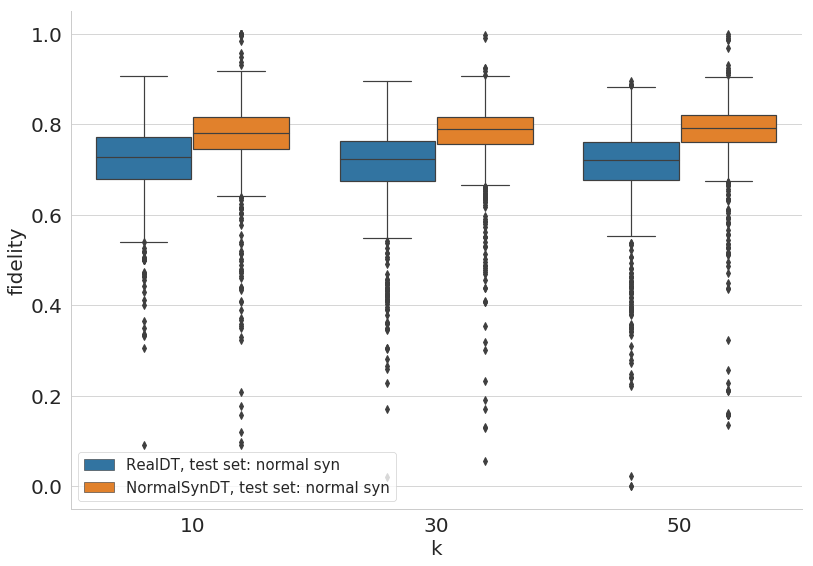

In [15]:
sns.set_style("whitegrid")

fidelities_df = pd.DataFrame(fidelities).T.reset_index()
fidelities_df = fidelities_df.rename(columns={'level_0':'i2e_id','level_1':'k',0:'RealDT, test set: normal syn',1:'NormalSynDT, test set: normal syn'})
fidelities_df = pd.melt(fidelities_df,
        id_vars=['k'], value_vars=['RealDT, test set: normal syn','NormalSynDT, test set: normal syn'],
                        var_name='', 
                        value_name='fidelity')
fig = plt.figure(figsize=(20,10))
sns.set_context("paper", rc={"font.size":20,
                             'legend.title_fontsize':10,
                             "axes.titlesize":20,
                             "axes.labelsize":20,
                             "xtick.labelsize":20,
                             "ytick.labelsize": 20,
                             "legend.fontsize":15})   
sns_plot = sns.catplot(x="k", 
                       y="fidelity",
                       hue="", 
                       kind="box", 
                       data=fidelities_df,
                       aspect=11.7/8.27,
                       height=8.27,
                       legend_out=False)
#title('Fidelities - no ontological information - ')
sns_plot.savefig("../fig/boxplot_fidelities_sequenceonly.png")
show()